# Assignment 3

Sven Den Hartog, s1003026 

Denise Klep, s4210646

In [14]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.datasets import TupleDataset
from chainer.cuda import to_cpu
from chainer import serializers
import matplotlib.pyplot as plt
import utils

In [15]:
# create toy data - compute sum of the previous and current input
def create_data(n=3000):

    X = np.random.rand(n,1).astype('float32')
    T = np.sum(np.hstack((X[0:-1],X[1:])),axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n,1])
    
    #rescale the data such that it fits the LSTM input activation scale. 
    #Divide by two because the sum of two is taken and then the output value fits a similar scale.
    X /= 2
    T /= 2

    return TupleDataset(X, T)

In [16]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None, 5)  # the first LSTM layer
            self.out = L.Linear(None, 1)  # the feed-forward output layer

    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        h = self.lstm(x)
        y = self.out(h)
        return y

In [17]:
model = RNN()
optimizer = optimizers.SGD()
optimizer.setup(model)

In [23]:
mean_acc = [] 
mean_test_loss = [] 
mean_train_loss = []
train_losses = []
test_losses = []
seqlen = 3000
epoch = 0
max_epoch = 20
#batches = 3
n_loss = 1
trainset = np.array(create_data())
testset = np.array(create_data())
while epoch < max_epoch:
    model.reset_state()
    loss = 0
    count = 0
    for i,x in enumerate(trainset):
        #print "Training data:" ,x
        prediction = model(np.expand_dims(x[0],0))
        #print "Prediction:", prediction
        loss = ((loss*(n_loss-1))+((prediction) - (trainset[i,1,0]))**2)/n_loss
        #loss += ((prediction) - trainset[i,1,0])**2
        #print "Pred shape:", np.shape(prediction)
        #print "Train shape:", np.shape(x[0])
        #loss = F.mean_squared_error(prediction,x[0])
        n_loss += 1
        count += 1
        if count % 30 == 0 or count == seqlen:
            model.cleargrads() #renew gradient calculations
            loss.backward() #runs error backpropagation
            loss.unchain_backward()
            n_loss = 1
            optimizer.update() #update variables
    #print(loss.data)
    train_losses.append(loss.data[0,0])
    #print np.shape(train_losses)
    
    #model.reset_state()
    loss_test = 0
    n_loss_test = 1
    for i,x in enumerate(testset):
        #print "Test sample:",x[0]
        prediction_test = model(np.expand_dims(x[0],0))
        #print "Prediction:",prediction_test
        loss_test = ((loss_test*(n_loss_test-1))+((prediction_test) - (testset[i,1,0]))**2)/n_loss_test
        n_loss_test += 1
    #print(loss_test.data)
    test_losses.append(loss_test.data[0,0])
    epoch += 1

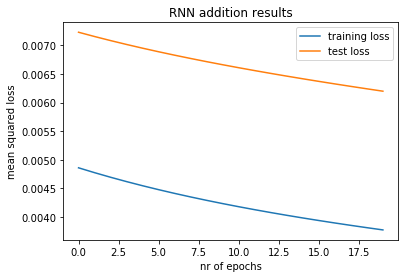

In [25]:
#visualize results for training and test loss values over the epochs
plt.xlabel('nr of epochs')
plt.ylabel('mean squared loss')
epochs = range(0,np.size(train_losses))
plt.plot(epochs,train_losses,
         label='training loss')
plt.plot(epochs,test_losses,
         label='test loss')
plt.legend(loc='upper right')
plt.title('RNN addition results')
plt.show()